<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-11/Session11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from model import resnet18
from utils import train, test, one_cycle_lr_scheduler, get_cifar10_data
from evaluate import plot_gradcam_images

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
epochs = 20
learning_rate = 0.01  # Lower learning rate to prevent gradient explosion
max_lr = 0.1  # Maximum learning rate for OneCycleLR
div_factor = 10  # Dividing factor for OneCycleLR
pct_start = 0.3  # Percentage of warm-up epochs for OneCycleLR

# Load CIFAR-10 data
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader, test_loader = get_cifar10_data(train_transform, test_transform, batch_size=batch_size)

# Create the ResNet model
model = resnet18(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler using OneCycleLR
scheduler = one_cycle_lr_scheduler(optimizer, max_lr=max_lr, total_epochs=epochs, steps_per_epoch=len(train_loader),
                                   div_factor=div_factor, pct_start=pct_start)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Training loop
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

for epoch in range(epochs):
    model.train()  # Set the model to train mode to enable gradients
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    scheduler.step()

# Save the trained model to a file
torch.save(model.state_dict(), 'resnet18_cifar10.pth')

Epoch 1/20, Train Loss: 1.5612, Train Acc: 42.95%, Test Loss: 1.4462, Test Acc: 48.96%
Epoch 2/20, Train Loss: 1.0454, Train Acc: 62.45%, Test Loss: 1.0657, Test Acc: 64.59%
Epoch 3/20, Train Loss: 0.7931, Train Acc: 72.26%, Test Loss: 0.8411, Test Acc: 71.20%
Epoch 4/20, Train Loss: 0.6673, Train Acc: 76.95%, Test Loss: 0.7172, Test Acc: 76.44%
Epoch 5/20, Train Loss: 0.5737, Train Acc: 80.16%, Test Loss: 0.6229, Test Acc: 79.09%
Epoch 6/20, Train Loss: 0.5028, Train Acc: 82.75%, Test Loss: 0.5373, Test Acc: 82.16%
Epoch 7/20, Train Loss: 0.4569, Train Acc: 84.15%, Test Loss: 0.5220, Test Acc: 82.23%
Epoch 8/20, Train Loss: 0.4191, Train Acc: 85.50%, Test Loss: 0.5564, Test Acc: 81.97%
Epoch 9/20, Train Loss: 0.3914, Train Acc: 86.53%, Test Loss: 0.4651, Test Acc: 84.86%
Epoch 10/20, Train Loss: 0.3643, Train Acc: 87.30%, Test Loss: 0.4741, Test Acc: 85.18%
Epoch 11/20, Train Loss: 0.3341, Train Acc: 88.59%, Test Loss: 0.4319, Test Acc: 86.06%
Epoch 12/20, Train Loss: 0.3105, Train Ac

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


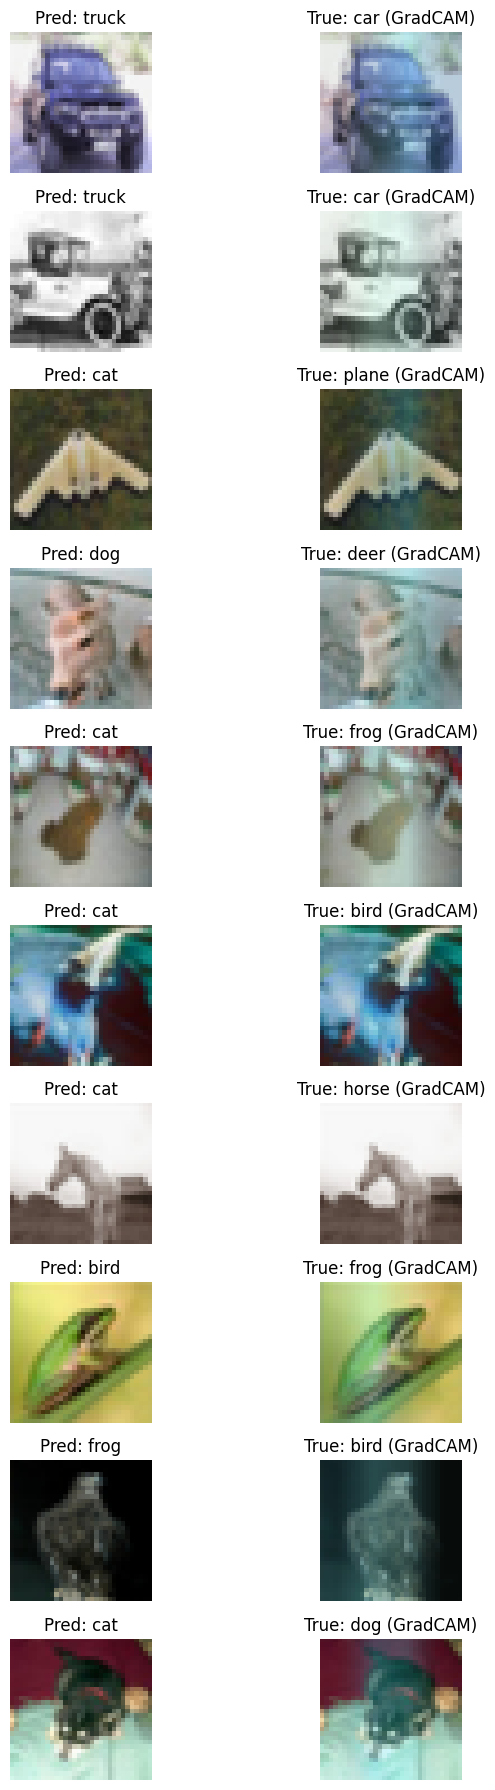

In [3]:
import torch
import torchvision.transforms as transforms
from model import resnet18
from evaluate import plot_gradcam_images

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 data for evaluation (if needed)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = get_cifar10_data(None, test_transform, batch_size=128)

# Load the saved model
model = resnet18(num_classes=10)
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Define the target layers for GradCAM
target_layers = [model.layer4[-1].conv2]

# Plot misclassified images with GradCAM overlay
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_gradcam_images(model, test_loader, device, classes, target_layers, num_images=10)
